In [2]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras.models import Sequential #regroupement de layer formant le modele
#dense == tensor ou layer ou ensemble de neurons d'un mm niveau 
 
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU, Activation #layer instance

#import la fct elu pour pouvoir gerer HP alpha
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras.losses import MeanSquaredLogarithmicError, MeanAbsolutePercentageError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, TensorBoard

from tensorflow.keras import backend as K

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

import numpy as np
import random
import time
from datetime import datetime

from src.vizu import *


2023-07-15 04:27:08.853130: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-15 04:27:09.203057: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-15 04:27:09.205715: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-15 04:27:11.020665: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
#previous dr 0.7




###HYPERPARAM###
# type d'archi qu'on veut 
architecture = [5,39, 40, 31, 42, 1]#small
#architecture = [5,61,51,28,39,26,21,20,14,1]

dropoutRate = 0.95 #0.5 va lisser les courbes
learningRate = 0.05  #peut etre augmenter car batchnormalisation # ou peut etre plus vite decroitre
expDecay = 0.96
rythm = 32
testPercent = 0.2
maxEpochs = 100#pas trop important car peut de chance d'overfitt
thresholdActi = 0
#! >=0  = pente pour tt x en dessous de thresold
alphaActi = 0 # 0.1 15% 0.3 25%S  ,36% pr 0.15
clipGrad = 1


seed_pre_shuffle = 50 #for numpy
seed_split = 40
seed_tf = 60
seed_python = 30
seed_numpy = 70
seed_ss = 90

seed_nb = 3

seed_pre_shuffle += seed_nb
seed_split += seed_nb
seed_tf += seed_nb
seed_python += seed_nb
seed_numpy += seed_nb
seed_ss += seed_nb


loss_function = MeanSquaredLogarithmicError()


def nrmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))/K.mean(y_true)

other_metrics = ['mape', nrmse]

monitorParam = 'loss'
loss_delta_stop = 0.0001
batchSize = 32 #pt 16


In [4]:
###ACTIVATION###

actMethod = relu
#actMethod = LeakyReLU(alpha=alphaActi)
#actMethod = sigmoid

In [5]:
###PREP TENSOR BOARD###

NAME = "CHF_hp_" + datetime.now().strftime("%Y%m%d-%H%M%S")
 
#pour avoir un resumé sur tensorboard
log_dir = "../logs/{}".format(NAME)  # Specify the directory where logs will be stored
tb = TensorBoard(log_dir=log_dir, histogram_freq=1)

#tensorboard --logdir logs/


AttributeError: module 'datetime' has no attribute 'now'

In [105]:
###SEED###

#seed for weights and all
tf.random.set_seed(seed_tf)

#seed for data shuffle
np.random.seed(seed_numpy)

#python seed to be sure
random.seed(seed_python)

In [106]:
###LOAD DATA###

data = pd.read_csv('./sort_data.csv') 

#print(data)


### Stratified Sampling###


#print('value counts',data['CHF'].value_counts(normalize=True)) #renvoie chaque valeurs de CHF diff avec la proportion

validation_data = data.groupby('CHF').apply(
    lambda x: x.sample(frac=testPercent, random_state=seed_ss)
).droplevel(0).sample(frac=1, random_state=seed_pre_shuffle)



#print(validation_data.loc[[4]]) #-> localiser sur base du label index et iloc si on veut la i eme ligne 

training_data = data.drop(
    validation_data.index
).sample(frac=1, random_state=seed_pre_shuffle)






X_train = training_data.iloc[:, 1:6].values #inputs
y_train = training_data.iloc[:, 7].values #target outputs

X_val = validation_data.iloc[:, 1:6].values
y_val = validation_data.iloc[:, 7].values

for i, j in enumerate(y_val):
    if j <=0:
        print(i)

# normalisation std  only training features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

#then use the normalisation of the first set
X_val = scaler.transform(X_val)


##import to save bc use it when want to predict
#mean_value = scaler.mean_
#std_deviation = scaler.scale_

#mean_tg = np.mean(y_train)
#std_tg = np.std(y_train)
#y_train = (y_train-mean_tg)/std_tg
#y_val = (y_val-mean_tg)/std_tg
#then use the normalisation of the first set






In [107]:
###INIT MODEL###


model = Sequential()
# Add the layers

for layer, neurons in enumerate(architecture[1:]):
    
    if layer == 0:
        model.add(Dense(neurons, input_shape=(architecture[0],)))
    else:
        model.add(Dense(neurons))
    model.add(Activation(actMethod))
    if  layer != len(architecture[1:]) - 1 :#and layer != len(architecture[1:]) - 2 :
        model.add(BatchNormalization())
        
    if layer == 0 or layer == 1:
        model.add(Dropout(dropoutRate))
    
    



model.compile(optimizer=Adam(learning_rate=learningRate), 
              loss=loss_function, metrics=other_metrics)


###Vizualisation###

#from keras.utils.vis_utils import plot_model
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

#visualize_nn(model, description=True, figsize=(100,100))#prend qq secondes + enregistre


In [108]:
###CALLBACKS###

#== modification/monitoring durant l'entrainement
#on stop qd plus de chgmt apres 50 epoch
early_stop = EarlyStopping(monitor=monitorParam,          #mieux de monitorer la loss car moins variable 
                           min_delta=loss_delta_stop,             #if nothing precise, it will check loss and stop after no change of >=0.1
                           patience=50, verbose=1,
                           restore_best_weights=True) #when stop ensure we keep best perf

# tt les 32 epochs lr perd 4%
#schedule == function to give to LearningScheduler, with epoch and lr as param
def lr_scheduler(epoch, lr):          #to modify and/or add to HP   
    if epoch % rythm == 0 and epoch > 0:
        return lr * expDecay
    return lr

learningRateScheduler = LearningRateScheduler(lr_scheduler)



In [109]:
###TRAINING###

#a partir d'ici que les weigghts sont crée 
history = model.fit(X_train, y_train,
                    shuffle=False,                  #comme ça on le fait ns mm avec une seed
                    validation_data=(X_val,y_val),
                    batch_size=batchSize, epochs=maxEpochs,
                    callbacks=[early_stop, learningRateScheduler, tb], #mpa_callback
                    verbose=1)                                    #progress bar

# resumé

model.summary()

Epoch 1/100
626/626 [==============================] - 6s 6ms/step - loss: 41.2632 - mape: 99.5440 - nrmse: 1.3024 - val_loss: 23.3682 - val_mape: 98.8709 - val_nrmse: 1.1940 - lr: 0.1000
Epoch 2/100
626/626 [==============================] - 3s 5ms/step - loss: 19.8659 - mape: 98.1455 - nrmse: 1.2967 - val_loss: 15.1540 - val_mape: 97.0664 - val_nrmse: 1.1851 - lr: 0.1000
Epoch 3/100
626/626 [==============================] - 3s 5ms/step - loss: 13.8963 - mape: 96.2021 - nrmse: 1.2888 - val_loss: 11.0269 - val_mape: 94.7486 - val_nrmse: 1.1736 - lr: 0.1000
Epoch 4/100
626/626 [==============================] - 3s 5ms/step - loss: 10.4392 - mape: 93.7616 - nrmse: 1.2787 - val_loss: 8.3430 - val_mape: 91.9199 - val_nrmse: 1.1589 - lr: 0.1000
Epoch 5/100
626/626 [==============================] - 3s 5ms/step - loss: 8.0760 - mape: 90.8463 - nrmse: 1.2659 - val_loss: 6.4539 - val_mape: 88.6823 - val_nrmse: 1.1407 - lr: 0.1000
Epoch 6/100
626/626 [==============================] - 3s 5ms/s

In [110]:

"""
history2 = model.fit(X_train, y_train,
                    shuffle=False,                  #comme ça on le fait ns mm avec une seed
                    validation_data=(X_val,y_val),
                    batch_size=batchSize, epochs=(maxEpochs+5),
                    callbacks=[early_stop, learningRateScheduler, tb], #mpa_callback
                    verbose=1)                                    #progress bar

# resumé

model.summary()
"""

'\nhistory2 = model.fit(X_train, y_train,\n                    shuffle=False,                  #comme ça on le fait ns mm avec une seed\n                    validation_data=(X_val,y_val),\n                    batch_size=batchSize, epochs=(maxEpochs+5),\n                    callbacks=[early_stop, learningRateScheduler, tb], #mpa_callback\n                    verbose=1)                                    #progress bar\n\n# resumé\n\nmodel.summary()\n'

loss


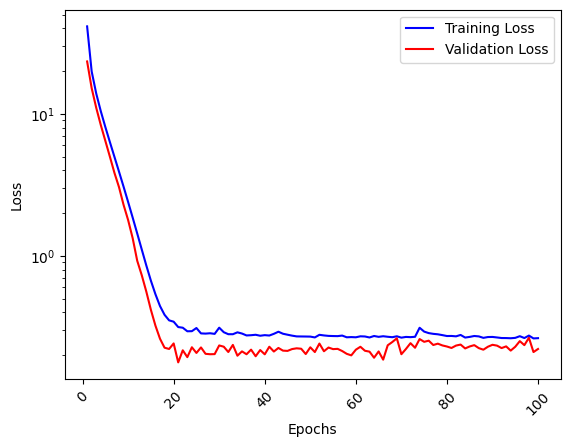

CHF_hp_test_seed_3_1689354962


In [111]:
###PLOT PERFORMANCE###
print(monitorParam)
import matplotlib.pyplot as plt

# Get the loss history from the model training
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plot the loss curves
epochs = range(1, len(training_loss) + 1)
plt.semilogy(epochs, training_loss, 'b-', label='Training Loss')
plt.semilogy(epochs, validation_loss, 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(rotation=45)



#plt.savefig('loss_plot1.png')

plt.show()
print(NAME)

In [131]:
predictions = np.array([i[0] for i in model.predict(X_val)])


mpe = (np.mean(np.abs(y_val - predictions) / np.mean(y_val))) * 100
print("pourcentage moyen d'erreur relative final  : ", mpe)

m = np.mean(y_val/predictions)



def my_std(y_val, predictions):
    MP = y_val/predictions
    
    std = 0
    for i in MP:
        std += (1-i)**2
    return np.sqrt(std/len(MP))
    
std = my_std(y_val,predictions)
print("mean :",m,"std :", std)


sum = 0
for i in range(len(y_val)):
    sum += (y_val[i]-predictions[i])**2

nrmse = np.sqrt(sum/len(y_val)) / np.mean(y_val)

print("NRMSE:", nrmse)







134/134 [==============================] - 0s 2ms/step
pourcentage moyen d'erreur relative final  :  28.42546536725974
mean : 0.9493646372267844 std : 0.3938389265059909
NRMSE: 0.3936258994218597


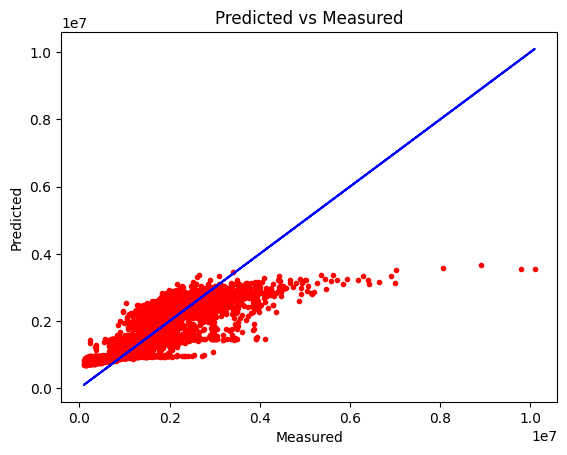

In [113]:



plt.figure()

plt.plot(y_val, predictions, '.r', label='')
plt.plot(y_val, y_val, 'b-', label='y=x')
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Predicted vs Measured')
#plt.savefig('test_strat100epoch.png')
plt.show()